## Research and advanced tools and process

Findings : 
- 1 For standardization, definition of a maximum length and automatically padd with 0 if the sequence has less frames.
[- (Too advanced for our deadlline on tf as only released on torch, but the concept of flash attention 2 on transformers from the paper released last month (stanford) has huge effect on memory and runtime. Using the asymmetric GPU memory hierarchy to bring significant memory saving (linear instead of quadratic), and runtime 2 to 4 times faster compared with optimized baseline. `flash attention 2 being specially impactful for long sequences`)]
- 2 Having the mean and the standard deviation of our hand position, as well as the decision of the dominant hand ! 
- 3 About 5% of the data character are spaces, though it seems like there is no sign character for it
- 4 On this link, the mean, std of hand ; as well as Xtrain, Xval, ytrain, yval... are already shared as input https://www.kaggle.com/code/m4nugnzl/aslfr-eda-preprocessing-dataset-for-beginners/output 
- 5 the end model config from the project having 0.675 - 4 About 5% of the data character are spaces, though it seems like there is no sign character for it ; chose GeLU activation function
- 6 embedding with keras (hand landmark and frames)
- 7 Awesome explaination of the transformer process with its code 
- 8 encoder and decoder architecture and code
- 9 loss function chose was categorical_crossentropy loss function with label smoothing support

## `paper and ressources :`

paper 'Sign Language Transformers: Joint End-to-end Sign Language Recognition and Translation - 11p' https://openaccess.thecvf.com/content_CVPR_2020/papers/Camgoz_Sign_Language_Transformers_Joint_End-to-End_Sign_Language_Recognition_and_Translation_CVPR_2020_paper.pdf

paper Stanford'flash attention (v1 2022) - 34p' https://arxiv.org/pdf/2205.14135.pdf

paper Stanford and its github 'flash attention 2 (v2 largely improved - end june 2023) - transformers runtime and memory more efficient for long sequences - 14p' https://arxiv.org/pdf/2307.08691.pdf ; github https://github.com/Dao-AILab/flash-attention

paper Google Cited 1059 times 'ViViT: A Video Vision Transformer - 14p' https://arxiv.org/pdf/2103.15691.pdf


## `Kaggle code reference :`
'ASLFR - Transformer Training Fully Explained' Well explained (results 0.675) https://www.kaggle.com/code/m4nugnzl/aslfr-transformer-training-fully-explained

'ASLFR CTC based on prev comp 1st place' different process, great to compare with the first one (results 0.687) https://www.kaggle.com/code/irohith/aslfr-ctc-based-on-prev-comp-1st-place

has been the main reference for the competition from its early stage publication but lot more efficient (results 0.441) : 'https://www.kaggle.com/code/gusthema/asl-fingerspelling-recognition-w-tensorflow#Google---American-Sign-Language-Fingerspelling-Recognition-with-TensorFlow'

'ASLFR EDA + Preprocessing Dataset for Beginners' https://www.kaggle.com/code/m4nugnzl/aslfr-eda-preprocessing-dataset-for-beginners#%F0%9F%93%84-Files

simpler version though decent (results 0.562) https://www.kaggle.com/code/husainattar/aslfr-a-simple-transformer


### The most interessing process found from the ASLFR - Transformer Training Fully Explained' Well explained (results 0.675) (https://www.kaggle.com/code/m4nugnzl/aslfr-transformer-training-fully-explained)

In [2]:
import numpy as np

### 1.  For the standardize of the length of input sequence, `N_TARGET_FRAMES` is defined as the variable that indicates the number of frames to which the recordings will be resized : 

In [ ]:
#Code

N_TARGET_FRAMES = 128

 # Pad Zeros
        N_FRAMES = len(data[0])
        if N_FRAMES < N_TARGET_FRAMES:
            data = tf.concat((
                data,
                tf.zeros([1,N_TARGET_FRAMES-N_FRAMES,N_COLS], dtype=tf.float32)
            ), axis=1)
        # Downsample
        data = tf.image.resize(
            data,
            [1, N_TARGET_FRAMES],
            method=tf.image.ResizeMethod.BILINEAR,
        )

This is done inside the class called `Preprocesseurlayer` below : 

In [ ]:
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()
        self.normalisation_correction = tf.constant(
                    # Add 0.50 to x coordinates of left hand (original right hand) and substract 0.50 of right hand (original left hand)
                     [0.50 if 'x' in name else 0.00 for name in LEFT_HAND_NAMES0],
                dtype=tf.float32,
            )
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_COLS0], dtype=tf.float32),),
    )
    def call(self, data0, resize=True):
        # Fill NaN Values With 0
        data = tf.where(tf.math.is_nan(data0), 0.0, data0)
        
        # Hacky
        data = data[None]
        
        # Empty Hand Frame Filtering
        hands = tf.slice(data, [0,0,0], [-1, -1, 84])
        hands = tf.abs(hands)
        mask = tf.reduce_sum(hands, axis=2)
        mask = tf.not_equal(mask, 0)
        data = data[mask][None]
        
        # Pad Zeros
        N_FRAMES = len(data[0])
        if N_FRAMES < N_TARGET_FRAMES:
            data = tf.concat((
                data,
                tf.zeros([1,N_TARGET_FRAMES-N_FRAMES,N_COLS], dtype=tf.float32)
            ), axis=1)
        # Downsample
        data = tf.image.resize(
            data,
            [1, N_TARGET_FRAMES],
            method=tf.image.ResizeMethod.BILINEAR,
        )
        
        # Squeeze Batch Dimension
        data = tf.squeeze(data, axis=[0])
        
        return data
    
preprocess_layer = PreprocessLayer()

#### 2. `To determine the dominant hand, and the mean ; std of position :` (from https://www.kaggle.com/code/m4nugnzl/aslfr-eda-preprocessing-dataset-for-beginners#%F0%9F%93%84-Files)

In [ ]:
def get_left_right_hand_mean_std():
    # Dominant Hand Statistics
    MEANS = np.zeros([N_COLS], dtype=np.float32)
    STDS = np.zeros([N_COLS], dtype=np.float32)
    
    # Plot
    fig, axes = plt.subplots(3, figsize=(20, 3*8))
    
    # Iterate over all landmarks
    for col, v in enumerate(tqdm(X.reshape([-1, N_COLS]).T)):
        v = v[np.nonzero(v)]
        # Remove zero values as they are NaN values
        MEANS[col] = v.astype(np.float32).mean()
        STDS[col] = v.astype(np.float32).std()
        if col in LEFT_HAND_IDXS:
            axes[0].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])
        elif col in RIGHT_HAND_IDXS:
            axes[1].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])
        else:
            axes[2].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])
        
    for ax, name in zip(axes, ['Left Hand', 'Right Hand', 'Lips']):
        ax.set_title(f'{name}', size=24)
        ax.tick_params(axis='x', labelsize=8, rotation=45)
        ax.set_ylim(0.0, 1.0)
        ax.grid(axis='y')

    plt.show()
    
    return MEANS, STDS

# Get Dominant Hand Mean/Standard Deviation
MEANS, STDS = get_left_right_hand_mean_std()
# Save Mean/STD to normalize input in neural network model
np.save('MEANS.npy', MEANS)
np.save('STDS.npy', STDS)

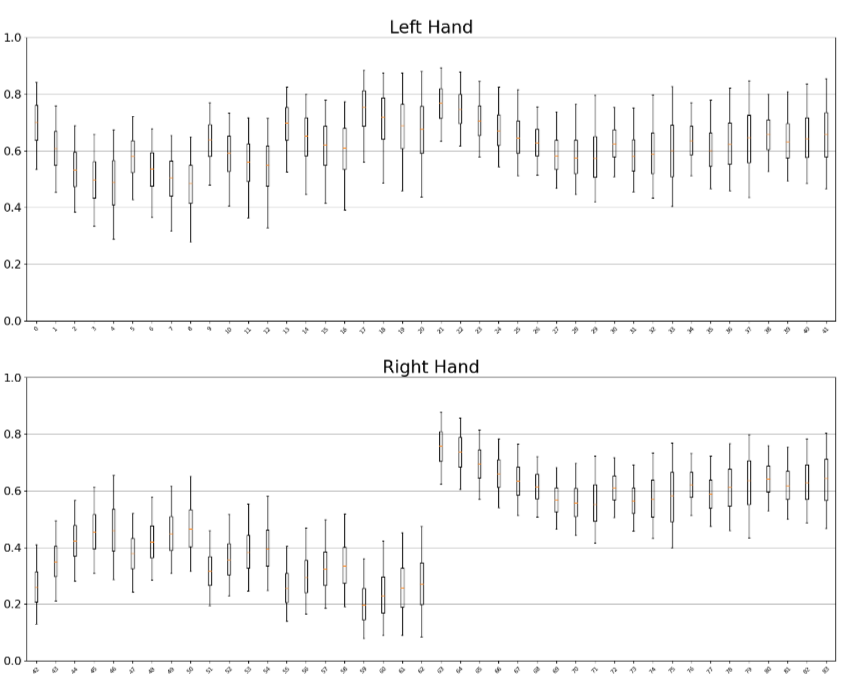

OR: 

In [ ]:
def get_idxs(df, words_pos, words_neg=[], ret_names=True, idxs_pos=None):
    idxs = []
    names = []
    for w in words_pos:
        for col_idx, col in enumerate(example_parquet_df.columns):
            # Exclude Non Landmark Columns
            if col in ['frame']:
                continue
                
            col_idx = int(col.split('_')[-1])
            # Check if column name contains all words
            if (w in col) and (idxs_pos is None or col_idx in idxs_pos) and all([w not in col for w in words_neg]):
                idxs.append(col_idx)
                names.append(col)
    # Convert to Numpy arrays
    idxs = np.array(idxs)
    names = np.array(names)
    # Returns either both column indices and names
    if ret_names:
        return idxs, names
    # Or only columns indices
    else:
        return idxs

In [ ]:
# Indices in processed data by axes with only dominant hand
HAND_X_IDXS = np.array(
        [idx for idx, name in enumerate(LEFT_HAND_NAMES0) if 'x' in name]
    ).squeeze()
HAND_Y_IDXS = np.array(
        [idx for idx, name in enumerate(LEFT_HAND_NAMES0) if 'y' in name]
    ).squeeze()
# Names in processed data by axes
HAND_X_NAMES = LEFT_HAND_NAMES0[HAND_X_IDXS]
HAND_Y_NAMES = LEFT_HAND_NAMES0[HAND_Y_IDXS]

### 3. Make some Ordinal encoding with all of our character from the label.

#### In total from the parquet analyzed we have 1 156 164 individual character (`cf updated data dictionary`, with a total of 288 761 individual number from 1 to 10, 661 474 individual letter from a to z and 213 929 special character including 58 569 space ' ')

#### therefore we might want to remove those cases with extremely few labels totaling 15 character from the 2 361 417 individual character.
'(':      16 
')':      16 
'$':       5     probably keep those still but up to argument


'!':       3 

'#':       3 

'*':       3 

''':       3 

'[':       2 

';':       1 

### `after further analysis, from the visuals and the research on signing, it seems like they don't sign the ' ', though present in estimated of about 5% of our data set (58 569/1 156 164). 

In [ ]:
# replace json with parquet, and file link to our
with open('/kaggle/input/asl-fingerspelling/character_to_prediction_index.json') as json_file:
    CHAR2ORD = json.load(json_file)

ORD2CHAR = {j:i for i,j in CHAR2ORD.items()}

display(pd.Series(CHAR2ORD).to_frame('Ordinal Encoding'))

### 4. Below, the link where some values such as X_train, X_val... and means, std of hand position result have been shared : https://www.kaggle.com/code/m4nugnzl/aslfr-eda-preprocessing-dataset-for-beginners/output 

In [7]:
file_path = 'd:\Téléchargements\X_val.npy'

# Load the .npy file
data = np.load(file_path)

# Now, 'data' contains the contents of the .npy file
# You can work with the data as needed
data.shape

(7236, 128, 164)

In [8]:
data

array([[[0.        , 0.        , 0.        , ..., 0.43832466,
         0.41966492, 0.4228143 ],
        [0.        , 0.        , 0.        , ..., 0.44109264,
         0.4193048 , 0.4217989 ],
        [0.        , 0.        , 0.        , ..., 0.44420236,
         0.41850525, 0.42100266],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.5346805 ,
         0.5203365 , 0.5228138 ],
        [0.        , 0.        , 0.        , ..., 0.5338256 ,
         0.5201627 , 0.52248377],
        [0.        , 0.        , 0.        , ..., 0.53411543,
         0.5201587 , 0.5224962 ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.5156937 ,
         0.5031233 , 0.50501925],
        [0. 

### 5. end Model config for transformer (activation gelu)

In [ ]:
# Epsilon value for layer normalisation
LAYER_NORM_EPS = 1e-6

# final embedding and transformer embedding size
UNITS_ENCODER = 384
UNITS_DECODER = 256

# Transformer
NUM_BLOCKS_ENCODER = 4
NUM_BLOCKS_DECODER = 2
NUM_HEADS = 4
MLP_RATIO = 2

# Dropout
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.30
MHA_DROPOUT_RATIO = 0.20
CLASSIFIER_DROPOUT_RATIO = 0.10

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
GELU = tf.keras.activations.gelu

### 6. embedding with keras

Embedding of the landmarks :

In [ ]:
# Embeds a landmark using fully connected layers
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, units, name):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.units = units
        self.supports_masking = True
        
    def build(self, input_shape):
        # Embedding for missing landmark in frame, initialized with zeros
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.units],
            initializer=INIT_ZEROS,)
        # Embedding: 2 dense layers
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM, activation=GELU),
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name=f'{self.name}_dense')

    def call(self, x):
        # if the landmark = 0 -> use empty embedding (return 0s), else use dense embedding
        return tf.where(
                # Checks whether landmark is missing in frame
                tf.reduce_sum(x, axis=2, keepdims=True) == 0,
                # If so, the empty embedding is used
                self.empty_embedding,
                # Otherwise the landmark data is embedded
                self.dense(x),
            )

In [ ]:
# Create an instance of the LandmarkEmbedding model
embedding_model = LandmarkEmbedding(units=2, name='landmark')

# Define the landmarks of the three frames
frame_1 = tf.constant([[[1, 2], [3, 4]]])
frame_2 = tf.constant([[[0, 0], [5, 6]], [[7, 8], [9, 10]]])

# Pass the landmarks through the embedding model
embedding_1 = embedding_model(frame_1)
embedding_2 = embedding_model(frame_2)

# Print the embedded representations of the landmarks
print(f'Frame 1 shape: {frame_1.shape} ')
print("Frame 1 embeddings:")
print(embedding_1)

print("\n\nFrame 2 embeddings:")
print(embedding_2)

embedding of each frame : 

In [ ]:
class Embedding(tf.keras.Model):
    def __init__(self):
        super(Embedding, self).__init__()
        self.supports_masking = True
    
    def build(self, input_shape):
        # Positional embedding for each frame index
        self.positional_embedding = tf.Variable(
            initial_value=tf.zeros([N_TARGET_FRAMES, UNITS_ENCODER], dtype=tf.float32),
            trainable=True,
            name='embedding_positional_encoder',)
        # Embedding layer for Landmarks
        self.dominant_hand_embedding = LandmarkEmbedding(UNITS_ENCODER, 'dominant_hand')

    def call(self, x, training=False):
        # Normalize data before aplying embedding
        x = tf.where(
                tf.math.equal(x, 0.0),
                0.0,
                (x - MEANS) / STDS,)
        # Dominant Hand: apply landmark embedding to extract information
        x = self.dominant_hand_embedding(x)
        # Add Positional Encoding
        x = x + self.positional_embedding
        
        return x

In [ ]:
# positional Embedding class
class PositionalEmbedding(tf.keras.Model):
    def __init__(self):
        super(PositionalEmbedding, self).__init__()
    
    def build(self, input_shape):
        self.positional_embedding = tf.Variable(
            initial_value=tf.zeros([1, 164], dtype=tf.float32),
            trainable=True,
            name='positional_embedding')
    
    def call(self, x):
        return x + self.positional_embedding

In [ ]:
# Create model instance
embedding_model = PositionalEmbedding()

# Define input data of dimension [1,1,164]
input_data = X_train[0,0,:].reshape(1,1,164)

# make the embedding
embedded_data = embedding_model(input_data)

print(f'Input Shape: {input_data.shape}')

print(f'\nEmbedded Shape: {embedded_data.shape}')

# Imprimir los datos de salida incrustados
print("\nInput Data:")
print(input_data)

print("\n\nEmbedded Data:")
print(embedded_data)

In summary, the Embedding class is used to generate an embedded representation for each input frame. This involves normalizing the input data, generating an embedded representation of the landmarks, and adding positional information to the resulting embedded representation.

7. Awesome explaination of the transformer process with its code 

Long explaination of the process and understanding to transformer architecture.

Now, a multi-head attention layer is implemented using the scaled dot product operation. Multi-head attention is a key component in Transformer models used in natural language processing tasks and other domains.

In a Transformer with multi-head attention, the concepts of queries, keys, and values are crucial as they are used to calculate attention between elements in a sequence. The attention mechanism in a Transformer allows it to focus on relevant parts of the input during the encoding or decoding stage. Attention is calculated at each position in the input sequence based on queries, keys, and values.

Here's an explanation of these three components:

Queries: These are vectors representing the current position in the input sequence for which attention is to be calculated. In other words, they are the positions that are being encoded or decoded. Each query is used to calculate the degree of relevance or similarity between this position and all other positions in the sequence.

Keys: These are vectors representing all positions in the input sequence. They are used to calculate the degree of relevance between queries and different positions in the sequence. Keys are crucial in determining which parts of the input are important for each query.

Values: These are vectors containing the actual information at each position in the input sequence. They are used to calculate attention weights and weigh the importance of each position based on its relevance to queries and keys.

The calculation of attention involves measuring the similarity between queries and keys to obtain attention weights. These attention weights indicate how much importance should be given to each position in the sequence based on its relationship with the current query. The values are then weighted using these attention weights to obtain the attended or contextualized representation of the current query.

In the context of multi-head attention, this process is performed multiple times, each time with different sets of parameters (queries, keys, and values), allowing the Transformer to capture different patterns and relationships in the input sequence more effectively.

We divide the explanation of our attention mechanism into steps:

scaled_dot_product is a function that performs the scaled dot product between the queries (q), keys (k), and values (v) of attention. The scaled dot product is a fundamental operation in attention, and it is used to calculate the relevance between queries and keys. In the context of multi-head attention, the scaled dot product is applied in parallel in each attention head to capture different relationships and patterns in the data. The process of the scaled dot product is done in three steps:

Dot Product: The dot product is calculated between the queries (q) and the transposed keys (k). This is achieved through the matrix multiplication operation. The result is a matrix representing the relevance between each pair of query and key.
Scaling: After calculating the dot product, it is scaled by dividing it by the square root of the dimension of the queries (q). This scaling operation helps stabilize the attention process and ensures that the attention values are not too large.
Softmax and Weighting: Next, a softmax function is applied to the scaled matrix. The softmax converts the values into a probability distribution, meaning that each attention value represents the relative importance of the corresponding key for a given query. Then, this attention distribution is used to weigh the values (v) and obtain a combined representation of the weighted values.

The reason we use this scaled dot product layer in multi-head attention is that it allows us to capture the relationships and dependencies between queries and keys more expressively. By performing the scaled dot product in multiple attention heads, we can capture different patterns and relationships in parallel, which enhances the ability to model relevant information in the data.

MultiHeadAttention is a multi-head attention layer. It takes as input the queries (q), keys (k), and values (v) of attention. It can also receive an optional attention mask to mask certain inputs. The main parameters of this layer are:

d_model: the dimension of the representation space for queries, keys, and values.
num_of_heads: the number of attention heads to be used.
dropout: the dropout probability to regularize the output.
d_out (optional): if provided, specifies the output dimension after the multi-head attention layer.
In the call method, the following operations are performed:
For each attention head, an independent linear transformation is applied to the queries (q), keys (k), and values (v) using dense layers (wq, wk, wv) to project them into smaller subspaces.
The scaled_dot_product function is called to calculate attention with the projections of q, k, and v for each attention head.
The outputs of all attention heads are concatenated along the last dimension to obtain a combined representation.
The combined representation goes through a final linear layer (wo) to obtain the output of the multi-head attention layer.
A dropout layer is applied to regularize the output before returning it.
In summary, this implementation performs multi-head attention in parallel, where each head learns different weighted representations of the inputs. Then, it combines the outputs of all heads into a final representation that can be used in natural language processing tasks and other machine learning problems.

Process : 
- First, we tokenize the sentence into word vectors or tokens
- Next, we calculate the similarity (e.g., using the dot product) between each query and each key to obtain the attention weights.
- The attention weights indicate which words are more relevant to each query. These weights are then applied to the values corresponding to the words in the input to obtain the final result.
- Finally, the multi-head attention combines the weighted representations of the words to obtain a high-quality representation for the original sentence.

In [ ]:
# cf https://www.kaggle.com/code/m4nugnzl/aslfr-transformer-training-fully-explained
# based on: https://stackoverflow.com/questions/67342988/verifying-the-implementation-of-multihead-attention-in-transformer
# replaced softmax with softmax layer to support masked softmax
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, dropout, d_out=None):
        super(MultiHeadAttention,self).__init__()
        # Number of Units in Model
        self.d_model = d_model
        # Number of Attention Heads
        self.n_heads = n_heads
        # Number of Units in Intermediate Layers
        self.depth = d_model // 2
        # Scaling Factor Of Values
        self.scale = 1.0 / tf.math.sqrt(tf.cast(self.depth, tf.float32))
        # Learnable Projections to Depth
        self.wq = self.fused_mha(self.depth)
        self.wk = self.fused_mha(self.depth)
        self.wv = self.fused_mha(self.depth)
        # Output Projection
        self.wo = tf.keras.layers.Dense(d_model if d_out is None else d_out, use_bias=False)
        # Softmax Activation Which Supports Masking
        self.softmax = tf.keras.layers.Softmax()
        # Reshaping Of Multiple Attention heads to Single Value
        self.reshape = tf.keras.Sequential([
            # [attention heads, number of frames, d_model] → [number of frames, n_heads, d_model // n_heads]
            tf.keras.layers.Permute([2, 1, 3]),
            # [number of frames, attention heads, d_model] → [number of frames, d_model]
            tf.keras.layers.Reshape([N_TARGET_FRAMES, self.depth]),
        ])
        # Output Dropout
        self.do = tf.keras.layers.Dropout(dropout)
        self.supports_masking = True
        
    # Single dense layer for all attention heads
    def fused_mha(self, dim):
        return tf.keras.Sequential([
            # Single dense layer
            tf.keras.layers.Dense(dim, use_bias=False),
            # Reshape to [number of frames, number of attention head, depth]
            tf.keras.layers.Reshape([N_TARGET_FRAMES, self.n_heads, dim // self.n_heads]),
            # Permutate to [number of attention heads, number of frames, depth]
            tf.keras.layers.Permute([2, 1, 3]),
        ])
        
    def call(self, q, k, v, attention_mask=None, training=False):
        # Projections to attention heads
        Q = self.wq(q)
        K = self.wk(k)
        V = self.wv(v)
        # Matrix multiply QxK to acquire attention scores
        x = tf.matmul(Q, K, transpose_b=True) * self.scale
        # Softmax attention scores and Multiply with Values
        x = self.softmax(x, mask=attention_mask) @ V
        # Reshape to flatten attention heads
        x = self.reshape(x)
        # Output projection
        x = self.wo(x)
        # Dropout
        x = self.do(x, training=training)
        return x

### 8. The encoder and decoder 

encoder :

In [ ]:
 # Encoder based on multiple transformer blocks
class Encoder(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Encoder, self).__init__(name='encoder')
        self.num_blocks = num_blocks
        self.supports_masking = True
    
    def build(self, input_shape):
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        # Make Transformer Blocks
        for i in range(self.num_blocks):
            # First Layer Normalisation
            self.ln_1s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(UNITS_ENCODER, NUM_HEADS, MHA_DROPOUT_RATIO))
            # Second Layer Normalisation
            self.ln_2s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Layer Perception
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS_ENCODER * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM, use_bias=False),
                tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(UNITS_ENCODER, kernel_initializer=INIT_HE_UNIFORM, use_bias=False),
            ]))
            # Optional Projection to Decoder Dimension
            if UNITS_ENCODER != UNITS_DECODER:
                self.dense_out = tf.keras.layers.Dense(UNITS_DECODER, kernel_initializer=INIT_GLOROT_UNIFORM, use_bias=False)
                self.apply_dense_out = True
            else:
                self.apply_dense_out = False
                
    def get_attention_mask(self, x_inp):
        # Attention Mask
        attention_mask = tf.math.count_nonzero(x_inp, axis=[2], keepdims=True, dtype=tf.int32)
        attention_mask = tf.math.count_nonzero(attention_mask, axis=[2], keepdims=False)
        attention_mask = tf.expand_dims(attention_mask, axis=1)
        attention_mask = tf.expand_dims(attention_mask, axis=1)
        return attention_mask
        
    def call(self, x, x_inp, training=False):
        # Attention mask to ignore missing frames
        attention_mask = self.get_attention_mask(x_inp)
        # Iterate input over transformer blocks
        for ln_1, mha, ln_2, mlp in zip(self.ln_1s, self.mhas, self.ln_2s, self.mlps):
            x = ln_1(x + mha(x, x, x, attention_mask=attention_mask))
            x = ln_2(x + mlp(x))
            
        # Optional Projection to Decoder Dimension
        if self.apply_dense_out:
            x = self.dense_out(x)
    
        return x

decoder steps are follow : 
The steps are as follows:

1 Preprocessing of the input sequence (phrase) is done to convert it into numerical representations (embedding) using the character embedding layer (char_emb). Additionally, the special start token (START_TOKEN) is added to the beginning of each sequence, and padding tokens (PAD_TOKEN) are appended at the end to reach the desired maximum length (MAX_PHRASE_LENGTH).

2 The causal attention mask is created using the get_causal_attention_mask method to prevent the model from accessing future information during sequence generation.

3 The initial embedding representations are obtained by summing the positional embedding layer (positional_embedding) and the character embedding layer (char_emb) of the input sequence (phrase). This sum combines spatial (positional) and semantic (character embedding) information for each word in the sequence.

4 A normalization layer (pos_emb_ln) is applied to the initial embedding representations after the causal masked attention (pos_emb_mha). Normalization helps the model train more stably and efficiently.

5 The Transformer blocks (normalization layers, multi-head attention, and MLP) are iterated through a for loop. Each block is responsible for processing and improving the embedding representations during sequence generation.

6 Finally, the generated sequence is trimmed to remove any padding tokens (PAD_TOKEN), and the output of the Decoder model with a length of MAX_PHRASE_LENGTH is obtained.

In summary, the Decoder model uses multiple Transformer blocks to generate an output sequence based on the information from the Encoder. It applies causal masked attention to capture temporal dependencies and uses normalization and MLP techniques to process and improve the embedding representations during sequence generation. The goal is for the model to generate meaningful and coherent text sequences based on the information from the Encoder.

In [ ]:
# Decoder based on multiple transformer blocks
class Decoder(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Decoder, self).__init__(name='decoder')
        self.num_blocks = num_blocks
        self.supports_masking = True
    
    def build(self, input_shape):
        # Causal Mask Batch Size 1
        self.causal_mask = self.get_causal_attention_mask()
        # Positional Embedding, initialized with zeros
        self.positional_embedding = tf.Variable(
            initial_value=tf.zeros([N_TARGET_FRAMES, UNITS_DECODER], dtype=tf.float32),
            trainable=True,
            name='embedding_positional_encoder',
        )
        # Character Embedding
        self.char_emb = tf.keras.layers.Embedding(N_UNIQUE_CHARACTERS, UNITS_DECODER, embeddings_initializer=INIT_ZEROS)
        # Positional Encoder MHA
        self.pos_emb_mha = MultiHeadAttention(UNITS_DECODER, NUM_HEADS, MHA_DROPOUT_RATIO)
        self.pos_emb_ln = tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS)
        # First Layer Normalisation
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        # Make Transformer Blocks
        for i in range(self.num_blocks):
            # First Layer Normalisation
            self.ln_1s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(UNITS_DECODER, NUM_HEADS, MHA_DROPOUT_RATIO))
            # Second Layer Normalisation
            self.ln_2s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Layer Perception
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS_DECODER * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM, use_bias=False),
                tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(UNITS_DECODER, kernel_initializer=INIT_HE_UNIFORM, use_bias=False),
            ]))
            
    def get_causal_attention_mask(self):
        i = tf.range(N_TARGET_FRAMES)[:, tf.newaxis]
        j = tf.range(N_TARGET_FRAMES)
        mask = tf.cast(i >= j, dtype=tf.int32)
        mask = tf.reshape(mask, (1, N_TARGET_FRAMES, N_TARGET_FRAMES))
        mult = tf.concat(
            [tf.expand_dims(1, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        mask = tf.tile(mask, mult)
        mask = tf.cast(mask, tf.float32)
        return mask
    
    def get_attention_mask(self, x_inp):
        # Attention Mask
        attention_mask = tf.math.count_nonzero(x_inp, axis=[2], keepdims=True, dtype=tf.int32)
        attention_mask = tf.math.count_nonzero(attention_mask, axis=[2], keepdims=False)
        attention_mask = tf.expand_dims(attention_mask, axis=1)
        attention_mask = tf.expand_dims(attention_mask, axis=1)
        return attention_mask
        
    def call(self, encoder_outputs, phrase, x_inp, training=False):
        # Batch Size
        B = tf.shape(encoder_outputs)[0]
        # Cast to INT32
        phrase = tf.cast(phrase, tf.int32)
        # Prepend SOS Token
        phrase = tf.pad(phrase, [[0,0], [1,0]], constant_values=START_TOKEN, name='prepend_sos_token')
        # Pad With PAD Token
        phrase = tf.pad(phrase, [[0,0], [0,N_TARGET_FRAMES-MAX_PHRASE_LENGTH-1]], constant_values=PAD_TOKEN, name='append_pad_token')
        # Positional Embedding
        x = self.positional_embedding + self.char_emb(phrase)
        # Causal Attention
        x = self.pos_emb_ln(x + self.pos_emb_mha(x, x, x, attention_mask=self.causal_mask))
        # Attention mask to ignore missing frames
        attention_mask = self.get_attention_mask(x_inp)
        # Iterate input over transformer blocks
        for ln_1, mha, ln_2, mlp in zip(self.ln_1s, self.mhas, self.ln_2s, self.mlps):
            x = ln_1(x + mha(x, encoder_outputs, encoder_outputs, attention_mask=attention_mask))
            x = ln_2(x + mlp(x))
        # Slice 31 Characters
        x = tf.slice(x, [0, 0, 0], [-1, MAX_PHRASE_LENGTH, -1])
    
        return x

### 9. mask function to prevent data leakage with the step as follow : 

1 The function creates a numeric sequence of length N_TARGET_FRAMES using tf.range(N_TARGET_FRAMES). Then, additional dimensions are added to this sequence using [:, tf.newaxis] to convert it into a column vector.

2 A Cartesian product is taken between the sequence created in step 1 and the original sequence using i >= j. This creates a matrix of zeros and ones, where the elements are zero in all positions corresponding to future positions (columns) relative to the current position (row).

3 The matrix of zeros and ones is reshaped to have a shape of (1, N_TARGET_FRAMES, N_TARGET_FRAMES). The additional dimension at the beginning is necessary for its later use in calculating the final mask.

4 The value of B is concatenated with a constant [1, 1] using tf.concat to create a tensor that specifies how many times the mask will be replicated to handle the batch size in the model.

5 tf.tile is used to replicate the causal attention mask B times, where B is the batch size. This is done so that the mask can be applied to all elements in the batch in the model.

6 The resulting attention mask is converted to a tensor of type float32 using tf.cast to ensure compatibility with the attention computation in TensorFlow. Finally, the function returns the resulting causal attention mask.

In [ ]:
# Causal Attention to make decoder not attent to future characters which it needs to predict
def get_causal_attention_mask(B):
    i = tf.range(N_TARGET_FRAMES)[:, tf.newaxis]
    j = tf.range(N_TARGET_FRAMES)
    mask = tf.cast(i >= j, dtype=tf.int32)
    mask = tf.reshape(mask, (1, N_TARGET_FRAMES, N_TARGET_FRAMES))
    mult = tf.concat(
        [tf.expand_dims(B, -1), tf.constant([1, 1], dtype=tf.int32)],
        axis=0,
    )
    mask = tf.tile(mask, mult)
    mask = tf.cast(mask, tf.float32)
    return mask

get_causal_attention_mask(1)

The loss function using the categorical_crossentropy loss function with label smoothing support.

When training a classification model, we typically use one-hot encoded labels or target outputs. In one-hot format, each sample has a label that is a binary vector with a "1" at the position corresponding to the true class and "0" in all other positions. For example, if we have a classification problem with 3 classes, a sample belonging to class 2 would have a label [0, 1, 0].

Label smoothing involves reducing the absolute confidence of the model in individual labels by redistributing a small amount of probability from the true class to other classes. Instead of using "1" at the position corresponding to the true class, a value close to "1" is used, and the rest of the value is distributed among the other classes.

The function contains the following elements:

idxs = tf.where(y_true != PAD_TOKEN): In this line, tf.where is used to find the positions in y_true where the value is not equal to the padding token (PAD_TOKEN). The goal is to filter out indices that do not correspond to padding tokens, as we do not want to consider them in the loss calculation.

y_true = tf.gather_nd(y_true, idxs): Here, tf.gather_nd is used to obtain the label values from y_true that are not padding tokens.

y_pred = tf.gather_nd(y_pred, idxs): Similarly, tf.gather_nd is used to obtain the model predictions corresponding to the filtered indices from y_true.

y_true = tf.cast(y_true, tf.int32): For the calculation of the loss with tf.keras.losses.categorical_crossentropy, y_true needs to be of type int32, so a conversion is performed.

y_true = tf.one_hot(y_true, N_UNIQUE_CHARACTERS, axis=1): The tf.one_hot function is used to convert the labels y_true into a one-hot representation.

loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.25, from_logits=True): Here, the loss is calculated using the categorical_crossentropy loss function. The function has an optional parameter label_smoothing, which is set to 0.25 in this case. The value 0.25 indicates how much "confidence" should be added to the true class and subtracted from the true class probability while adding to the other classes in the loss. from_logits=True indicates that y_pred has not been passed through a softmax activation function before calculating the loss.

loss = tf.math.reduce_mean(loss): Finally, the loss calculated in the previous step is reduced to a single value by taking its average using tf.math.reduce_mean. This is necessary to obtain a single loss measure representing the overall model performance on the dataset.